In [1]:
# Import all libraries
import os
import yaml
import zipfile
import cv2
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image


In [3]:
# Config file
RAW_PATH = "../../data/raw/"
PROCESSED_PATH = "../../data/processed/"

In [11]:
# Utils file
def clean(filename):
    if filename:
        for file in os.listdir(RAW_PATH):
            os.remove(os.path.join(RAW_PATH, file))
    else:
        raise ValueError("File not found".capitalize())
    
def config():
    with open("../../deafult_params.yml", "r") as file:
        return yaml.safe_load(file)
    
def dump_pickle(value = None, filename = None):
    if value is not None and filename is not None:
        joblib.dump(value = value, filename=filename)
        
def load_pickle(filename = None):
    return joblib.load(filename)

In [19]:
class Loader:
    def __init__(self, image_path = None, batch_size = 32):
        self.image_path = image_path
        self.batch_size = batch_size
        self.directory = None
        self.categories = None
        self.base_images = list()
        self.mask_images = list()
        self.is_mask = "mask"

    def base_transformation(self):
        return transforms.Compose(
            [
                transforms.Resize(
                    (config()["data"]["image_width"], config()["data"]["image_height"])
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                    ],
                    std=[
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                    ],
                ),
            ]
        )

    def mask_transformation(self):
        return transforms.Compose(
            [
                transforms.Resize(
                    (config()["data"]["image_width"], config()["data"]["image_height"])
                ),
                transforms.ToTensor(),
                transforms.Grayscale(
                    num_output_channels=config()["data"]["gray_channels"]
                ),
                transforms.Normalize(
                    mean=[
                        config()["data"]["transforms"],
                    ],
                    std=[
                        config()["data"]["transforms"],
                    ],
                ),
            ]
        )

    def unzip_folder(self):
        if os.path.exists(RAW_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(os.path.join(RAW_PATH))
        else:
            os.makedirs(RAW_PATH)

    def create_dataloader(self):
        self.directory = os.path.join(RAW_PATH, os.listdir(RAW_PATH)[0])
        self.categories = os.listdir(self.directory)

        for category in self.categories:
            folder_path = os.path.join(self.directory, category)
            for image in os.listdir(folder_path):
                if self.is_mask in image:
                    continue

                base_image = image.split(".")[0]
                extension = image.split(".")[1]
                mask_image = "{}_{}.{}".format(base_image, self.is_mask, extension)
                
                self.base_images.append(
                    self.base_transformation()(
                        Image.fromarray(cv2.imread(os.path.join(folder_path, image)))))

                self.mask_images.append(
                    self.mask_transformation()(
                        Image.fromarray(cv2.imread(os.path.join(folder_path, mask_image),
                                                    cv2.IMREAD_GRAYSCALE
                ))))

        if os.path.exists(PROCESSED_PATH):
            dataloader = DataLoader(
                dataset=list(zip(self.base_images, self.mask_images)), batch_size=self.batch_size, shuffle=True
                )
            dump_pickle(value=self.base_images, filename=os.path.join(PROCESSED_PATH, "base_images.pkl"))
            dump_pickle(
                value=self.mask_images,
                filename=os.path.join(PROCESSED_PATH, "mask_images.pkl"),
            )
            dump_pickle(
                value=dataloader,
                filename=os.path.join(PROCESSED_PATH, "dataloader.pkl"),
            )

            return dataloader

        else:
            raise Exception("PROCESSED_PATH does not exist".capitalize())


if __name__ == "__main__":
    loader = Loader(
        image_path="/Users/shahmuhammadraditrahman/Desktop/semantic.zip", batch_size=32
    )
    loader.unzip_folder()
    dataloader = loader.create_dataloader()

In [20]:
data, label = next(iter(dataloader))
data.size()

torch.Size([32, 3, 256, 256])

In [14]:
import joblib

data = joblib.load(
    "/Users/shahmuhammadraditrahman/Desktop/U-Net/data/processed/dataloader.pkl"
)

data, label = next(iter(data))

print(data.shape)

torch.Size([32, 3, 256, 256])


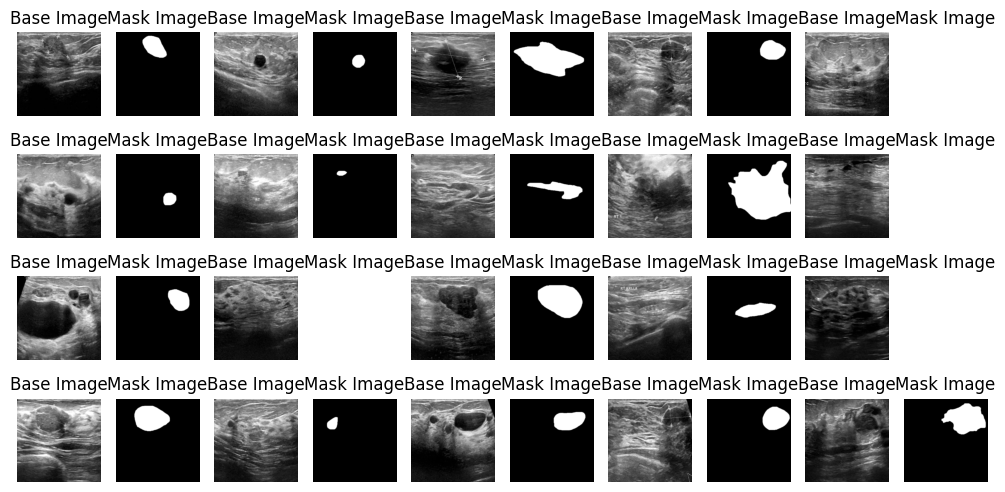

In [21]:
import matplotlib.pyplot as plt
def display_images():
    num_samples = 20
    plt.figure(figsize=(10, 10))
    dataloader = load_pickle(
            filename=os.path.join(PROCESSED_PATH, "dataloader.pkl")
        )
    images, labels = next(iter(dataloader))
    images = images[:num_samples]
    labels = labels[:num_samples]

    for index, image in enumerate(images):
        plt.subplot(2 * 4, 2 * 5, 2 * index + 1)
        image = image.permute(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image, cmap="gray")
        plt.title("Base Image")
        plt.axis("off")

        plt.subplot(2 * 4, 2 * 5, 2 * index + 2)
        label = labels[index].permute(1, 2, 0)
        label = (label - label.min()) / (label.max() - label.min())
        plt.imshow(label, cmap="gray")
        plt.title("Mask Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_images()

In [4]:
from collections import OrderedDict

class Encoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.encoder_block()

    def encoder_block(self):
        layers = OrderedDict()
        layers["conv1"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["relu1"] = nn.ReLU(inplace=True)
        layers["conv2"] = nn.Conv2d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["batch_norm1"] = nn.BatchNorm2d(self.out_channels)
        layers["relu2"] = nn.ReLU(inplace=True)

        return nn.Sequential(layers)

    def forward(self, x):
        return self.model(x) if x is not None else None
    
if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    assert encoder(torch.randn(64, 3, 256, 256)).shape == (64, 64, 256, 256)